In [1]:
import numpy as np
import torch
import torch.nn.functional as F

In [2]:
# !pip install open-tamil
import tamil
import codecs
from tamil import utf8

with open('./tamil_names.txt') as f:
    names_data = list(map(tamil.utf8.get_letters, list(map(str.strip, f.readlines()))))
names_data[0]

['அ', 'க', 'த்', 'தி', 'ய', 'ன்']

In [3]:
# create i_to_s and s_to_i mapping dict 
chars = ['.'] + sorted(set([j for i in names_data for j in i]))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}
len(itos)

209

In [4]:
X, Y = [], []
block_size = 3
for w in names_data[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ['.']:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join([itos[i] for i in context]), '-->' , ch)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

['அ', 'க', 'த்', 'தி', 'ய', 'ன்']
['அ', 'க', 'நே', 'ய', 'ன்']
['அ', 'க', 'ர', 'ன்']
['அ', 'க', 'ல்', 'யா']
['அ', 'கி', 'ல', 'ன்']


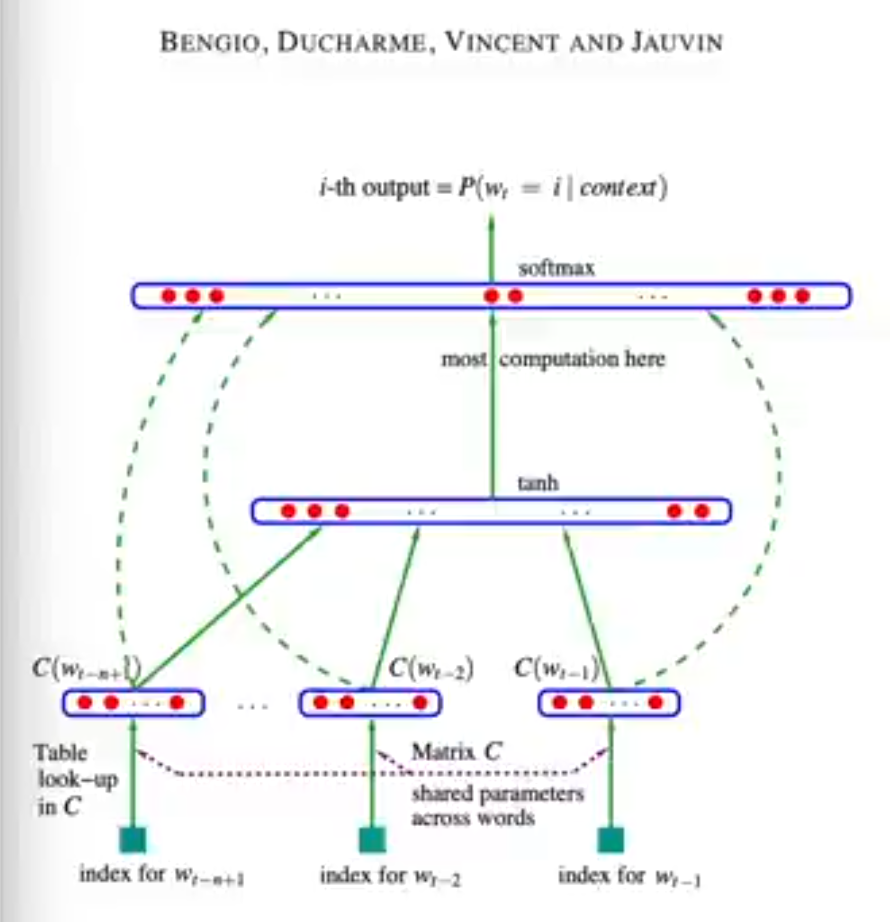

In [12]:
C = torch.rand((209, 2))

In [15]:
# (no_of_input, n_embedding)
C.shape

torch.Size([209, 2])

In [18]:
# get the embedding for all the input X
emb = C[X]
emb.shape

torch.Size([28, 3, 2])

In [17]:
# 1st layer, lets say 100 neurons
W = torch.rand((6, 100))
b = torch.rand(100)

In [20]:
h = torch.tanh(emb.view(-1, W.shape[0]) @ W +b)
h

tensor([[0.9609, 0.9469, 0.9905,  ..., 0.9205, 0.9984, 0.9884],
        [0.9589, 0.9399, 0.9893,  ..., 0.9075, 0.9983, 0.9834],
        [0.9417, 0.8748, 0.9851,  ..., 0.8889, 0.9951, 0.9882],
        ...,
        [0.9497, 0.8949, 0.9836,  ..., 0.8651, 0.9964, 0.9705],
        [0.9074, 0.7848, 0.9573,  ..., 0.7511, 0.9875, 0.9262],
        [0.8778, 0.8334, 0.9427,  ..., 0.7870, 0.9790, 0.9656]])

In [45]:
X, Y = [], []
block_size = 3
for w in names_data:
    #print(w)
    context = [0] * block_size
    for ch in w + ['.']:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join([itos[i] for i in context]), '-->' , ch)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([16869, 3]), torch.Size([16869]))

In [46]:
num_classes, block_size, n_emb = len(stoi), 3, 2
num_classes, block_size, n_emb

(209, 3, 2)

In [47]:
g = torch.Generator().manual_seed(1337)
C = torch.rand((num_classes, n_emb) , generator=g)
W1 = torch.rand((n_emb * block_size, 100), generator = g)
b1 = torch.rand(100, generator = g)

W2 = torch.rand((W1.shape[1], num_classes), generator = g)
b2 = torch.rand(num_classes, generator = g)

parameters = [C, W1, b1, W2, b2]

In [48]:
# n parameters
sum([p.nelement() for p in parameters])

22227

In [49]:
# set grads
for n in parameters:
    n.requires_grad = True

In [62]:
for _ in range(1000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,) ) # (0, X.shape[0]) -> 32 of them
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + b1)
    logits = (h @ W2 +b2)
    #counts = logits.exp()
    #probs = count/ counts.sum(1, keepdim=True)
    #loss = -probs[np.arange(num_classes),y].log().mean()
    
    loss = F.cross_entropy(logits, Y[ix])    
    # zero grad
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())


3.261467933654785


In [63]:
with torch.no_grad():
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + b1)
    logits = (h @ W2 +b2)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

3.390399217605591


In [69]:
g = torch.Generator().manual_seed(1337)
for i in range(10):
    outs = []
    context = [0] * block_size
    while True:
        emb = C[ torch.tensor( [context] ) ]
        h = torch.tanh( emb.view(-1, block_size * n_emb) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        outs.append(itos[ix])
    print(''.join(outs))

விளப்ஷியகநானே
கங்ளி
கசுயன்
காந்தி
கத்
மோசிவி
கவர்
துனமூலி
கோககாணத்ர்
ககுலசி


## PyTorchified

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Constants (set these appropriately)
num_classes = 10        # Example
n_emb = 32              # Embedding size
block_size = 8          # Input sequence length
hidden_size = 100       # Hidden layer size

# Dummy dataset (replace with your real X and Y tensors)
X = torch.randint(0, num_classes, (1000, block_size))  # shape: (num_samples, block_size)
Y = torch.randint(0, num_classes, (1000,))             # shape: (num_samples,)

# Define the model
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, n_emb)
        self.fc1 = nn.Linear(block_size * n_emb, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        emb = self.embedding(x)                          # (batch, block_size, n_emb)
        emb_flat = emb.view(x.shape[0], -1)              # Flatten to (batch, block_size * n_emb)
        h = torch.tanh(self.fc1(emb_flat))               # Hidden layer
        logits = self.fc2(h)                             # Output layer
        return logits

# Set manual seed
torch.manual_seed(1337)

# Initialize model and optimizer
model = SimpleMLP()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
for step in range(1000):
    # Minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    x_batch = X[ix]
    y_batch = Y[ix]

    # Forward pass
    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(loss.item())